In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import itertools
from collections import defaultdict, OrderedDict
from random import shuffle
from tqdm import tqdm_notebook as tqdm, tnrange as trange
from sklearn.metrics import confusion_matrix

from evalResult import get_predicted, get_observed
plt.style.use('seaborn')

In [2]:
dataset = 'EN'

## Hyperparameters
Here for easy tuning.

In [3]:
# optimal 1e-4
lr = 1e-4
n_epochs = 20

## Data

### Cleaning
Prepare words for cleaning. Specifically, find
1. ~~stopwords~~
1. punctuation
1. hashtags
1. @ mentions
1. numbers
1. URLs

In [4]:
re_punc = r'^[^a-zA-Z0-9]+$'
re_hash = r'^#'
re_at = r'^@'
re_num = r'\d'  # just remove all words with numbers
re_url = r'(^http:|\.com$)'

In [5]:
def clean_word(w):
    w = w.strip()
    if re.match(re_punc, w):
        return '#PUNC#'
    if re.match(re_hash, w):
        return '#HASH#'
    if re.match(re_at, w):
        return '#AT#'
    if re.match(re_num, w):
        return '#NUM#'
    if re.match(re_url, w):
        return '#URL#'
    return w.lower()

### I/O

In [6]:
def parse(train_filename):
    with open(train_filename, 'r') as f:
        lines = f.readlines()

    observations, states = defaultdict(int), defaultdict(int)
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            obs, state = data_split
            observations[clean_word(obs)] += 1
            states[state] += 1
    return observations, states

In [7]:
def read_file(filename, clean=True):
    with open(filename, 'r') as f:
        lines = f.readlines()
        
    sentence, label = [], []
    sentences, labels = [], []
    for line in lines:
        data_split = line.strip().rsplit(' ', 1)
        if len(data_split) == 2:
            word, state = data_split
            if clean:
                word = clean_word(word)
            sentence.append(word)
            label.append(state)
        else:
            sentences.append(sentence)
            labels.append(label)
            sentence = []
            label = []
    return sentences, labels

### Train data

In [8]:
train_filename = f'data/{dataset}/train'

observations, states = parse(train_filename)

In [9]:
train_sentences, train_labels = read_file(train_filename)
train_sentences[0][:5], train_labels[0][:5]

(['rt', '#AT#', '#PUNC#', 'encore', '#PUNC#'], ['O', 'O', 'O', 'B-INTJ', 'O'])

## Encoding

In [10]:
def one_hot_encode(n, depth):
    a = np.zeros([depth, 1])
    a[n, 0] = 1
    return a

### Encode words
Create a vocabulary out of words that appear more than `1` time(s) in training. Each word now maps to an _integer_. Other words will be treated as `#UNK#`.

In [11]:
def tokenize(token_mapping, sentence):
    """
    Function to convert each word into its corresponding integer
    If word is not found, return the value for '#UNK'
    """
    return [token_mapping.get(w, token_mapping['#UNK#']) for w in sentence]

def prepare_inputs(token_mapping, sentences):
    """
    Converts a 2-D list of sentences (list of list of words)
    to one-hot encoded tokens of shape [n_sentences, n_words, len(token_mapping), 1].
    """
    tokens = [tokenize(token_mapping, sentence) for sentence in sentences] 
    
    depth = len(token_mapping)
    one_hot_tokens = [[one_hot_encode(token, depth) for token in sentence] for sentence in tokens]
    one_hot_tokens = [np.asarray(ls) for ls in one_hot_tokens]  # list of [n_words, len(token_mapping), 1]
    return one_hot_tokens

In [12]:
min_freq = 0

token_mapping = {}
for word in observations:
    if observations[word] > min_freq:  # appears more than once in training
        token_mapping[word] = len(token_mapping)
token_mapping['#UNK#'] = len(token_mapping)
len(token_mapping)

2504

In [13]:
X_train = prepare_inputs(token_mapping, train_sentences)
len(X_train), X_train[0].shape

(551, (25, 2504, 1))

## `word2vec`
$$ h = Wx $$
$$ o = Uh $$
$$ \hat{y} = \text{softmax}(o) $$

In [14]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

### Initialization

In [15]:
np.random.seed(0)

vocab_size = len(token_mapping)
latent_size = 300

W = np.random.normal(0, 0.1, size=[latent_size, vocab_size])
U = np.random.normal(0, 0.1, size=[vocab_size, latent_size])

### Forward

In [16]:
def forward(W, U, x):
    h = W.dot(x)
    o = U.dot(h)
    y_ = softmax(o)
    return y_

y_ = forward(W, U, X_train[0][0])
y_.shape

(2504, 1)

In [17]:
list(token_mapping)[np.argmax(y_)]

'instructions'

### Backward

In [18]:
def backward(W, U, x, y):
    h = W.dot(x)
    o = U.dot(h)
    y_ = softmax(o)
    
    do = y_ - y
    dU = do.dot(h.T)
    dW = U.T.dot(do).dot(x.T)
    grad = (dW, dU)
    
    assert dU.shape == U.shape
    assert dW.shape == W.shape
    
    xent = -np.log(y_ + 1e-8) * y
    loss = np.sum(xent)
    return loss, grad

loss, (dW, dU) = backward(W, U, X_train[0][0], X_train[0][1])
dW.shape, dU.shape

((300, 2504), (2504, 300))

### Training

In [19]:
def save_model(i, W, U):
    np.save(f'weights/word2vec/W_{i+1}', W)
    np.save(f'weights/word2vec/U_{i+1}', U)

In [20]:
def train_sentence(W, U, sentence):
    for i in range(len(sentence)):
        # python allows indexing beyond len(list), but not before
        if i <= 2:
            context = np.concatenate([sentence[:i], sentence[i+1:i+3]])
        else:
            context = np.concatenate([sentence[i-2:i], sentence[i+1:i+3]])
        # positive sampling
        center_word = sentence[i]
        for context_word in context:
            _, (dW, dU) = backward(W, U, center_word, context_word)  # center as input, context as target
            W -= lr * dW
            U -= lr * dU
        

def train_epoch(i, W, U, X):
    for sentence in tqdm(X, leave=False):
        train_sentence(W, U, sentence)
    save_model(i, W, U)

for i in trange(10):
    train_epoch(i, W, U, X=X_train)

## Visualization

In [21]:
def word2vec(one_hot_vector):
    weights = 0.5 * (W + U.T)
    return weights.dot(one_hot_vector)

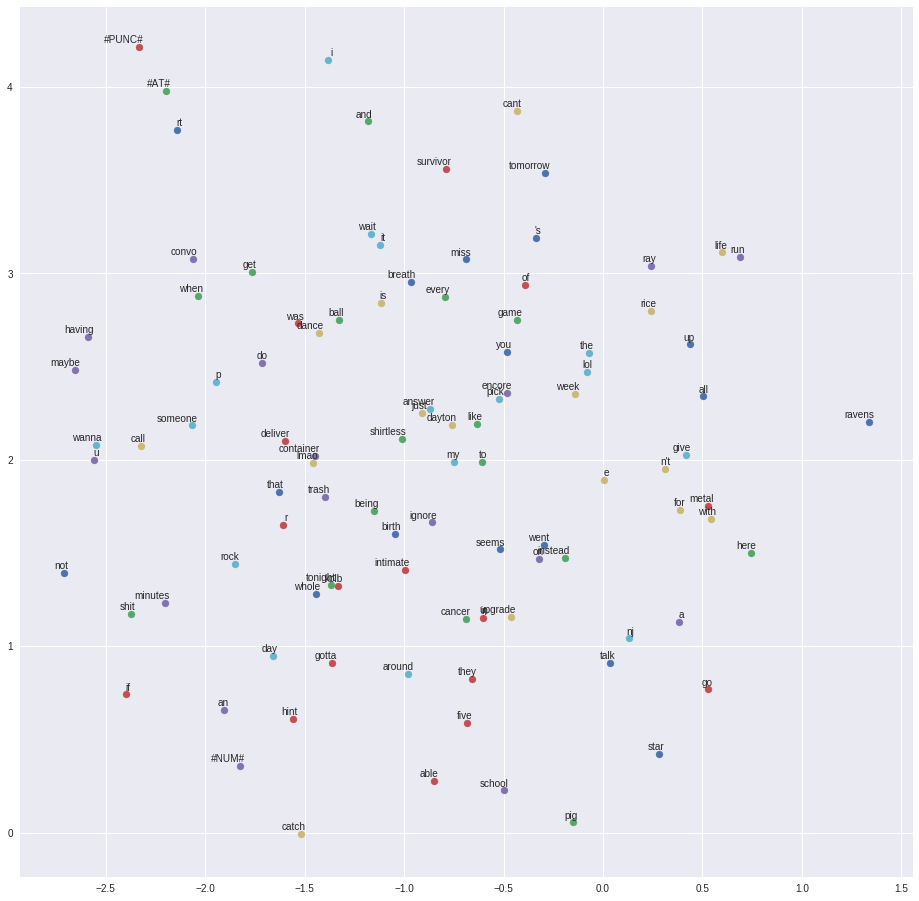

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot():
    labels = []
    tokens = []
    
    count = 0
    for word in observations:
        # to speed up the process, let's limit to the first 100 elements
        if count < 100:
            token = token_mapping[word]
            one_hot = one_hot_encode(token, len(token_mapping))
            vec = word2vec(one_hot).flatten()
            tokens.append(vec)
            labels.append(word)
            count = count+1

    # set the t-sne values
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot()